# Validate Galpro
----

<h4> Description </h4>
Here we validate Galpro on a different dataset, SDSS+GALEX+WISE. We want to test how the ML algorithm performs for high stellar mass galaxies. Altough we retrieve the stellar masses from SDSS+GALEX+WISE, the photometry is from DES.


In [1]:
import numpy as np
import astropy.io.ascii as at
import scipy.stats as st


import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import os

sns.set_style("whitegrid")
sns.set_context('talk',rc={"lines.linewidth": 2.5})

In [2]:
fname = '../data/des_sdssGalexWISE_matched.csv'
check_sample = os.path.isfile(fname)

In [3]:
if not check_sample:
    print('Please run notebook 5.mathcSDSS+GALEX+WISE')

In [4]:
if check_sample:
    data = at.read(fname)

In [5]:
print('Sample size: %i'%len(data))
data[:5]

Sample size: 32542


sof_cm_mag_corrected_i,sof_cm_mag_err_i,sof_cm_mag_err_g,sof_cm_mag_corrected_g,flags_gold,ra,sof_cm_mag_corrected_z,sof_cm_mag_err_r,sof_cm_mag_err_z,coadd_object_id,dec,extended_class_mash_sof,id,sof_cm_mag_corrected_r,SDSS,sdss_z,sdss_mass,sdss_mass_err,sdss_sfr,sdss_sfr_err,sdss_ra,sdss_dec,mass_ml
float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,int64,int64,float64,str4,float64,float64,float64,float64,float64,int64,int64,float64
16.98233021878081,0.0027048216201074993,0.0022124961296476624,17.400159105751722,0,45.0748532941083,16.884993356957935,0.0020542148263706047,0.003538746715524895,333405907,0.1108993203048,3,832,17.091226631263595,True,0.0622,9.542,0.043,-0.045,0.017,45,0,9.045379599999988
16.87850663087113,0.00392364400464531,0.004087661650421609,17.728132371425655,0,45.0905808215014,16.726703714106467,0.0033619032744842264,0.00479338907924165,333404919,0.136597550261526,3,893,17.180752853575196,True,0.1026,10.258,0.055,0.424,0.083,45,0,10.050084296935418
16.74501141312942,0.0027457288421850385,0.0037817387334222125,18.146212256904427,0,45.1525754833688,16.451187021607787,0.00250839722092937,0.0029829555256407026,333397114,0.329832276044419,3,4794,17.14066707505175,True,0.1716,11.139,0.048,0.405,0.155,45,0,10.8525
17.377194284582604,0.0038354655372996203,0.002986987870781861,17.745309436229444,0,45.2151915521039,17.28134443502677,0.0028132257397968266,0.005040596391335554,333397366,0.355736171196189,3,4908,17.45748111231161,True,0.0281,8.841,0.044,-0.793,0.02,45,0,7.93227709999999
16.749152331067457,0.0028590587004658063,0.004038132313166454,18.36414502314037,0,44.8390461060415,16.428986171003505,0.0027262845574862835,0.003032579837937653,333398925,0.279437422419731,3,6140,17.21704293101248,True,0.1893,11.472,0.021,0.515,0.105,44,0,11.126777000000002


## Running: Galpro

In [6]:
import sys

sys.path.append('/home/s1/jesteves/git/ccopa/python/galpro')
import model
from convert_mag_to_lupmag import get_input_galpro

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [7]:
## create a true vector with abs_mag, colors, z

In [9]:
mags = np.c_[[data['sof_cm_mag_corrected_%s'%bp_filter] for bp_filter in ['g','r','i','z']]].T
mags_err = np.c_[[data['sof_cm_mag_err_%s'%bp_filter] for bp_filter in ['g','r','i','z']]].T
ztrue= data['sdss_z']

x_target = get_input_galpro(mags,ztrue)

In [10]:
y_target = np.array(data['sdss_mass'])#np.zeros(x_target[:,0].size,dtype=float)[:,np.newaxis]

In [134]:
x_train = np.load('/data/des61.a/data/johnny/DESY3/galpro_files/DES_WF/data/x_train.npy')
y_train = np.load('/data/des61.a/data/johnny/DESY3/galpro_files/DES_WF/data/y_train.npy')

x_test = np.load('/data/des61.a/data/johnny/DESY3/galpro_files/DES_WF/data/x_test.npy')
y_test = np.load('/data/des61.a/data/johnny/DESY3/galpro_files/DES_WF/data/y_test.npy')

In [135]:
def transform_to_1d(x,y):
    ynew = y[:,1]
    xnew = np.vstack([x.T,y[:,0]]).T
    return xnew, ynew[:,np.newaxis]

In [136]:
x_test1d, y_test1d = transform_to_1d(x_test,y_test)
x_train1d, y_train1d = transform_to_1d(x_train,y_train)

In [14]:
gp_root = '/data/des61.a/data/johnny/DESY3/galpro_files/DES_WF/'
gpmodel = model.Model('model_1d_des', x_train1d, y_train1d, x_target, root=gp_root, save_model=True)


('path:', '/data/des61.a/data/johnny/DESY3/galpro_files/DES_WF/model_1d_des/')
Model directory exists.


/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.20.3 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.20.3 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Loaded model.


In [15]:
point_estimates0 = gpmodel.point_estimate(save_estimates=False, make_plots=True)

Generating point estimates...


In [16]:
data['mass_ml'] = point_estimates0
data.write(fname,overwrite=True)

In [17]:
gpmodel2 = model.Model('model_1d_des', x_train1d, y_train1d, x_test1d, root=gp_root, save_model=True)
point_estimates = gpmodel2.point_estimate(save_estimates=False, make_plots=True)

('path:', '/data/des61.a/data/johnny/DESY3/galpro_files/DES_WF/model_1d_des/')
Model directory exists.
Loaded model.
Generating point estimates...


### Feature Importance

In [18]:
import time
import numpy as np

forest = gpmodel.model
start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print("Elapsed time to compute the importances: {elapsed_time:.3f} seconds".format(elapsed_time=elapsed_time))

Elapsed time to compute the importances: 0.699 seconds


In [19]:
feature_names = ['mag_%s'%bpF for bpF in ['g','r','i','z']]
feature_names+= ['%s - %s'%(bp0,bp1) for bp0, bp1 in zip(['g','r','i'],['r','i','z'])]

feature_names+= ['Mag_err_%s'%bpF for bpF in ['g','r','i','z']]
feature_names+= ['Err(%s - %s)'%(bp0,bp1) for bp0, bp1 in zip(['g','r','i'],['r','i','z'])]
feature_names+= ['redshift']
feature_names

['mag_g',
 'mag_r',
 'mag_i',
 'mag_z',
 'g - r',
 'r - i',
 'i - z',
 'Mag_err_g',
 'Mag_err_r',
 'Mag_err_i',
 'Mag_err_z',
 'Err(g - r)',
 'Err(r - i)',
 'Err(i - z)',
 'redshift']

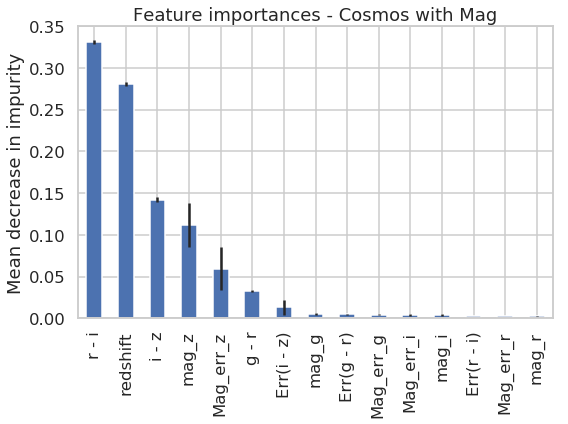

In [20]:
import pandas as pd

ix = np.argsort(-1*importances)
forest_importances = pd.Series(importances[ix], index=np.array(feature_names)[ix])

fig, ax = plt.subplots(figsize=(8,6))
forest_importances.plot.bar(yerr=std[ix], ax=ax)
ax.set_title("Feature importances - Cosmos with Mag")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
fig.savefig('feature_importance_mag.png',dpi=100,transparent=False,facecolor='w')

# Validation

In [21]:
def get_nmad(x):
    mad = np.nanmedian(x)
    nmad = 1.48*np.nanmedian(np.abs(x-mad))
    return nmad, mad

In [22]:
colors = -99*np.ones((len(mags[:,0]),3))

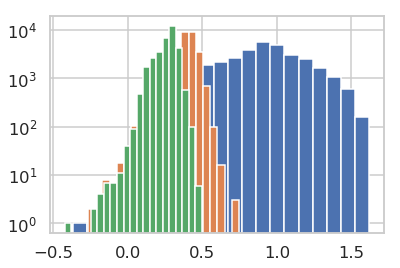

In [23]:
for i in range(3):
    colors[:,i] = mags[:,i]-mags[:,i+1]
    plt.hist(mags[:,i]-mags[:,i+1],bins=21)
    
plt.yscale('log')

In [24]:
crazy_colors= -1.,4.
def mask_crazy_colors(colors,color_lims):
    mask = (colors[:,0]>color_lims[0])&(colors[:,0]<color_lims[1])
    mask &= (colors[:,1]>color_lims[0])&(colors[:,1]<color_lims[1])
    mask &= (colors[:,2]>color_lims[0])&(colors[:,2]<color_lims[1])
    return mask

In [25]:
res1 = point_estimates0-y_target#data['mass_ml'] - data['sdss_mass']

In [26]:
mlow = 8.
mask = mask_crazy_colors(colors, crazy_colors)
# mask &= x_target[:,2]>=14.
# mask &= x_target[:,-1]>=0.2
mask &= (y_target>mlow)#&(x_target[:,-1]<0.3)

In [27]:

# snmad0,mean0 = get_nmad(res0)
# snmad01,mean01 = get_nmad(res0[mask])

snmad1,mean1 = get_nmad(res1)
snmad11,mean11 = get_nmad(res1[mask])
print('z<0.3 and mass>%.2fE10'%mlow)
print('median, sigma: %.3f, %.3f'%(mean11,snmad11))
print('\n')

z<0.3 and mass>8.00E10
median, sigma: -0.384, 0.214




In [28]:
# for i in range(3):
#     #colors[:,i] = mags[:,i]-mags[:,i+1]
#     plt.hist(mags[mask,i],bins=21)
# plt.yscale('log')

In [29]:
def plot_scatter(x,y,ax=None,s=20,alpha=0.5,title='',xlims=(mlow,12.)):
    if ax is None: ax = plt.axes()
    ax.plot(xlims,xlims,'k--',lw=2)
    ax.scatter(x,y,s=s,alpha=alpha)
    ax.set_title(title)
    

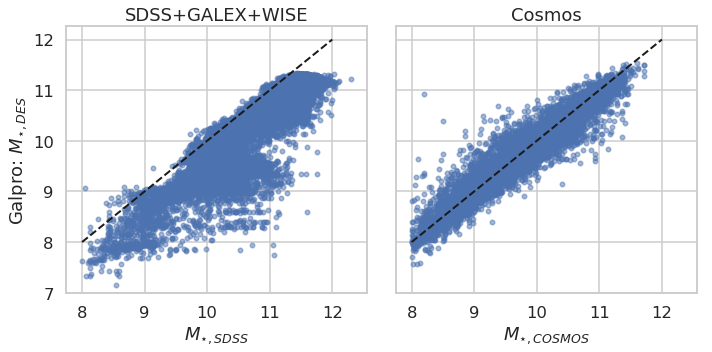

In [30]:
fig, axis = plt.subplots(1, 2, figsize=(10,5), sharex='all',sharey='all')
fig.subplots_adjust(wspace=0.04)
plot_scatter(y_test1d[y_test1d[:,0]>mlow,0],point_estimates[y_test1d[:,0]>mlow],
             ax=axis[1],s=20,alpha=0.5,title='Cosmos',xlims=(mlow,12.))

plot_scatter(y_target[mask],point_estimates0[mask],
             ax=axis[0],s=20,alpha=0.5,title='SDSS+GALEX+WISE',xlims=(mlow,12.))
axis[0].set_ylim(mlow-1,)
axis[0].set_xlabel(r'$M_{\star,SDSS}$')
axis[1].set_xlabel(r'$M_{\star,COSMOS}$')
axis[0].set_ylabel(r'Galpro: $M_{\star,DES}$')
fig.tight_layout()
fig.savefig('validation_galpro.png',dpi=100,transparent=False,facecolor='w')

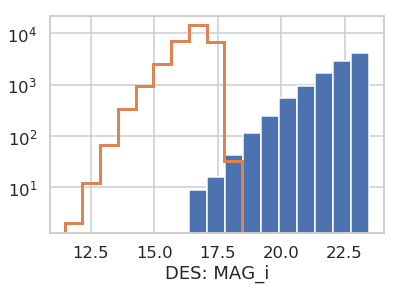

In [31]:
plt.hist(x_test1d[:,2],label='COSMOS')
plt.hist(x_target[mask,2],histtype='step',label='SDSS+GALEX+WISE',lw=3)
plt.yscale('log')
plt.xlabel('DES: MAG_i')
fig.savefig('validation_galpro_mag_histogram.png',dpi=100,transparent=False,facecolor='w')

(-2, 0.5)

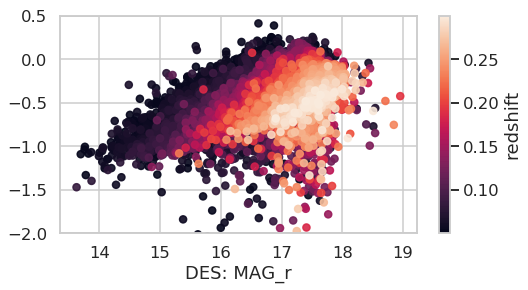

In [32]:
plt.figure(figsize=(8,4))
mask2 = (y_target>9.)&(x_target[:,-1]>0.05)
ix = np.argsort(x_target[mask2,-1])
plt.scatter(mags[mask2,1][ix],res1[mask2][ix],c=x_target[mask2,-1][ix],s=50,alpha=0.9)
plt.colorbar().set_label('redshift')
plt.xlabel('DES: MAG_r')
plt.ylim(-2,+.5)

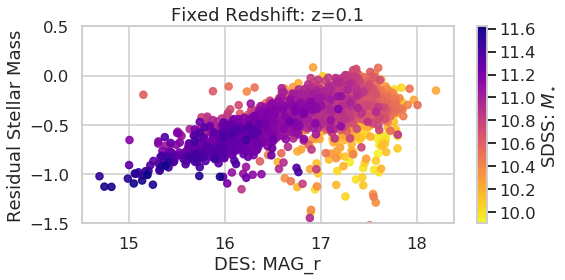

In [33]:
plt.figure(figsize=(8,4))
mask2 = (y_target>9.9)&(np.abs(x_target[:,-1]-0.1)<0.01)
ix = np.argsort(y_target[mask2])
plt.scatter(mags[mask2,1][ix],res1[mask2][ix],c=y_target[mask2][ix],s=50,alpha=0.9,cmap='plasma_r')
plt.colorbar().set_label('SDSS: $M_{\star}$')
plt.ylim(-1.5,+.5)
plt.ylabel('Residual Stellar Mass')
plt.xlabel('DES: MAG_r')
plt.title('Fixed Redshift: z=0.1')
plt.tight_layout()
plt.savefig('validation_galpro_mag_residual_fixed_redshift.png',dpi=100,transparent=False,facecolor='w')

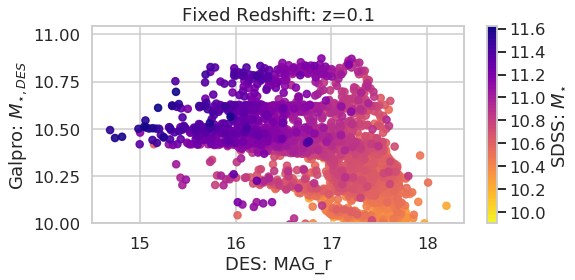

In [34]:
plt.figure(figsize=(8,4))
mask2 = (y_target>9.9)&(np.abs(x_target[:,-1]-0.1)<0.01)
ix = np.argsort(y_target[mask2])
plt.scatter(mags[mask2,1][ix],point_estimates0[mask2][ix],c=y_target[mask2][ix],s=50,alpha=0.9,cmap='plasma_r')
plt.colorbar().set_label('SDSS: $M_{\star}$')
plt.ylim(10.,)
plt.ylabel(r'Galpro: $M_{\star,DES}$')
plt.xlabel('DES: MAG_r')
plt.title('Fixed Redshift: z=0.1')
plt.tight_layout()
plt.savefig('validation_galpro_stellarMass_mag_fixed_redshift.png',dpi=100,transparent=False,facecolor='w')

Text(0.5,0,'redshift')

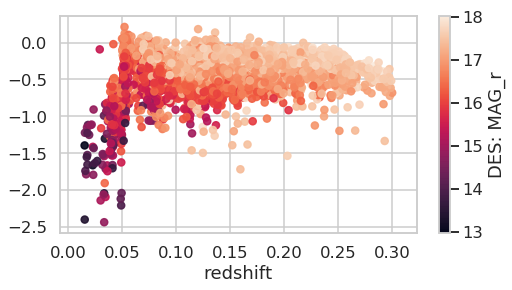

In [35]:
plt.figure(figsize=(8,4))
mask2 = y_target>10.
ix = np.argsort(-1*mags[mask2,1][ix])
plt.scatter(x_target[mask2,-1][ix],res1[mask2][ix],c=mags[mask2,1][ix],s=50,alpha=0.9)
plt.colorbar().set_label('DES: MAG_r')
plt.xlabel('redshift')

# Refine The Model: Absolute Mag

In [36]:

# distMod = cosmo.distmod(x_target[:,-1]).value

In [37]:
from astropy.cosmology import WMAP9 as cosmo

def get_input_galpro2(mags, magsErr, redshift, a=2.5*np.log10(np.exp(1)), f_o=10**12):
    lups, lup_errors = convert_mag_to_lupmag(mags, a=a, f_o=f_o)
    distMod = cosmo.distmod(redshift).value
    absMags = lups-distMod[:,np.newaxis]
    g_r = lups[:, 0] - lups[:, 1]
    r_i = lups[:, 1] - lups[:, 2]
    i_z = lups[:, 2] - lups[:, 3]

    # colour errors
    g_r_err = ((lup_errors[:, 0]**2) + (lup_errors[:, 1]**2))**0.5
    r_i_err = ((lup_errors[:, 1]**2) + (lup_errors[:, 2]**2))**0.5
    i_z_err = ((lup_errors[:, 2]**2) + (lup_errors[:, 3]**2))**0.5

    # combining everything
    x_target = np.c_[absMags, g_r, r_i, i_z, magsErr, g_r_err, r_i_err, i_z_err, redshift]
    return x_target


In [38]:
x_target_abs = get_input_galpro2(mags,mags_err,ztrue)
x_test1d_abs = get_input_galpro2(x_test1d[:,:4],x_test1d[:,4:8],x_test1d[:,-1])
x_train1d_abs = get_input_galpro2(x_train1d[:,:4],x_train1d[:,4:8],x_train1d[:,-1])

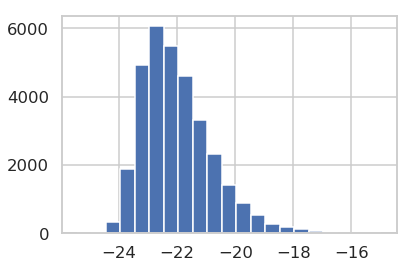

In [39]:
for i in [2]:
    plt.hist(x_target_abs[:,i],bins=21)

In [40]:
gp_root = '/data/des61.a/data/johnny/DESY3/galpro_files/DES_WF/'
gpmodel2 = model.Model('model_AbsMag', x_train1d_abs, y_train1d, x_target_abs, root=gp_root, save_model=True)


('path:', '/data/des61.a/data/johnny/DESY3/galpro_files/DES_WF/model_AbsMag/')
Model directory exists.
Loaded model.


In [41]:
point_estimates1 = gpmodel2.point_estimate(save_estimates=False, make_plots=True)

Generating point estimates...


In [42]:
res2 = point_estimates1-y_target
snmad1,mean1 = get_nmad(res2)
snmad11,mean11 = get_nmad(res2[y_target>mlow])
print('z<0.3 and mass>%.2fE10'%mlow)
print('median, sigma: %.3f, %.3f'%(mean11,snmad11))
print('\n')

z<0.3 and mass>8.00E10
median, sigma: -0.339, 0.127




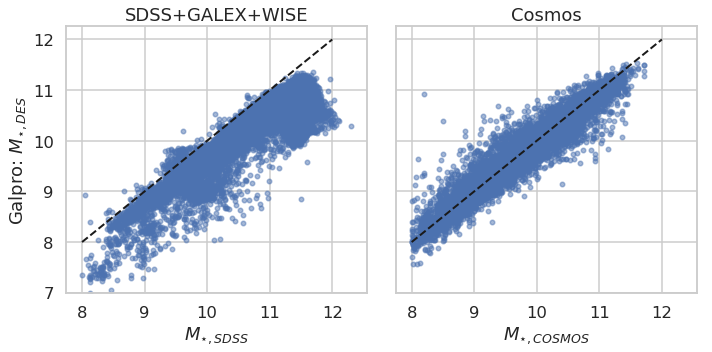

In [43]:
fig, axis = plt.subplots(1, 2, figsize=(10,5), sharex='all',sharey='all')
fig.subplots_adjust(wspace=0.04)
plot_scatter(y_test1d[y_test1d[:,0]>mlow,0],point_estimates[y_test1d[:,0]>mlow],
             ax=axis[1],s=20,alpha=0.5,title='Cosmos',xlims=(mlow,12.))

plot_scatter(y_target[y_target>mlow],point_estimates1[y_target>mlow],
             ax=axis[0],s=20,alpha=0.5,title='SDSS+GALEX+WISE',xlims=(mlow,12.))
axis[0].set_ylim(mlow-1,)
axis[0].set_xlabel(r'$M_{\star,SDSS}$')
axis[1].set_xlabel(r'$M_{\star,COSMOS}$')
axis[0].set_ylabel(r'Galpro: $M_{\star,DES}$')
fig.tight_layout()
fig.savefig('validation_galpro.png',dpi=100,transparent=False,facecolor='w')

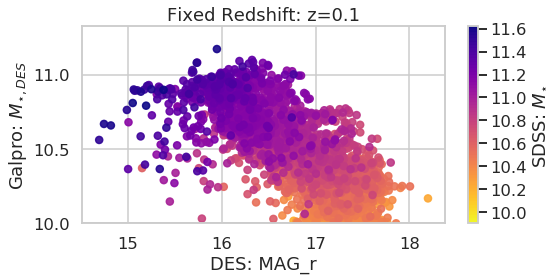

In [44]:
plt.figure(figsize=(8,4))
mask2 = (y_target>9.9)&(np.abs(x_target[:,-1]-0.1)<0.01)
ix = np.argsort(y_target[mask2])
plt.scatter(mags[mask2,1][ix],point_estimates1[mask2][ix],c=y_target[mask2][ix],s=50,alpha=0.9,cmap='plasma_r')
plt.colorbar().set_label('SDSS: $M_{\star}$')
plt.ylim(10.,)
plt.ylabel(r'Galpro: $M_{\star,DES}$')
plt.xlabel('DES: MAG_r')
plt.title('Fixed Redshift: z=0.1')
plt.tight_layout()
plt.savefig('validation_galpro_absMag_stellarMass_mag_fixed_redshift.png',dpi=100,transparent=False,facecolor='w')

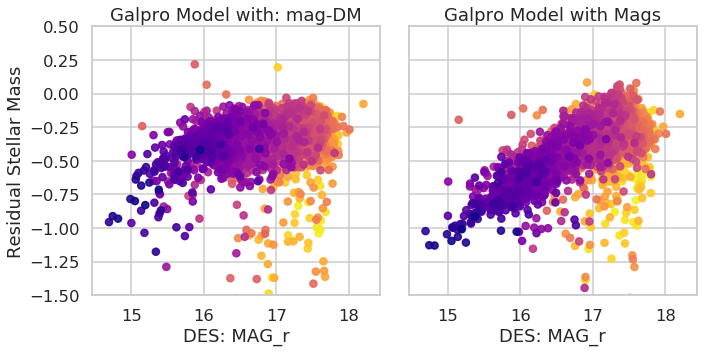

In [45]:
fig, axis = plt.subplots(1, 2, figsize=(10,5), sharex='all',sharey='all')
fig.subplots_adjust(wspace=0.01)

mask2 = (y_target>9.9)&(np.abs(x_target[:,-1]-0.1)<0.01)
ix = np.argsort(y_target[mask2])
axis[0].scatter(mags[mask2,1][ix],(point_estimates1-y_target)[mask2][ix],c=y_target[mask2][ix],
            s=50,alpha=0.9,cmap='plasma_r')
axis[0].set_title('Galpro Model with: mag-DM')

axis[1].scatter(mags[mask2,1][ix],res1[mask2][ix],c=y_target[mask2][ix],
            s=50,alpha=0.9,cmap='plasma_r')
axis[1].set_title('Galpro Model with Mags')

# axis[0].colorbar().set_label('SDSS: $M_{\star}$')
axis[0].set_ylim(-1.5,+.5)
axis[0].set_ylabel('Residual Stellar Mass')
axis[0].set_xlabel('DES: MAG_r')
axis[1].set_xlabel('DES: MAG_r')


plt.tight_layout()
plt.savefig('validation_galpro_mag_residual_fixed_redshift.png',dpi=100,transparent=False,facecolor='w')

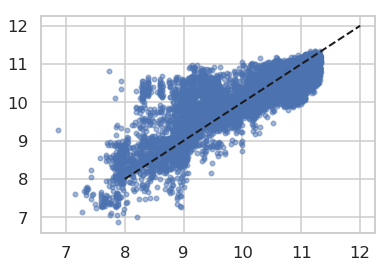

In [46]:
plot_scatter(point_estimates0,point_estimates1)

### Feature Importance

In [47]:
import time
import numpy as np

forest = gpmodel2.model
start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print("Elapsed time to compute the importances: {elapsed_time:.3f} seconds".format(elapsed_time=elapsed_time))

Elapsed time to compute the importances: 0.664 seconds


In [48]:
feature_names = ['Abs_mag_%s'%bpF for bpF in ['g','r','i','z']]
feature_names+= ['%s - %s'%(bp0,bp1) for bp0, bp1 in zip(['g','r','i'],['r','i','z'])]

feature_names+= ['Mag_err_%s'%bpF for bpF in ['g','r','i','z']]
feature_names+= ['Err(%s - %s)'%(bp0,bp1) for bp0, bp1 in zip(['g','r','i'],['r','i','z'])]
feature_names+= ['redshift']
feature_names

['Abs_mag_g',
 'Abs_mag_r',
 'Abs_mag_i',
 'Abs_mag_z',
 'g - r',
 'r - i',
 'i - z',
 'Mag_err_g',
 'Mag_err_r',
 'Mag_err_i',
 'Mag_err_z',
 'Err(g - r)',
 'Err(r - i)',
 'Err(i - z)',
 'redshift']

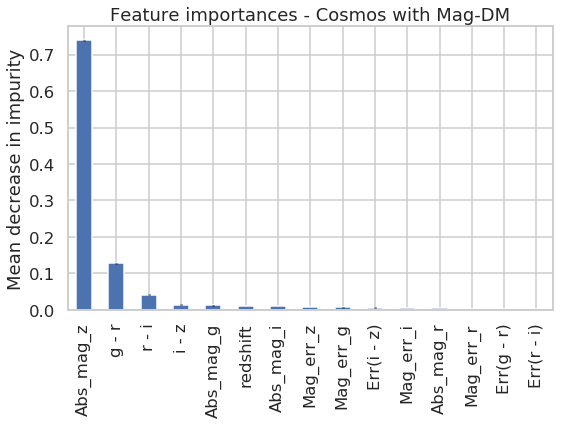

In [49]:
import pandas as pd

ix = np.argsort(-1*importances)
forest_importances = pd.Series(importances[ix], index=np.array(feature_names)[ix])

fig, ax = plt.subplots(figsize=(8,6))
forest_importances.plot.bar(yerr=std[ix], ax=ax)
ax.set_title("Feature importances - Cosmos with Mag-DM")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
fig.savefig('feature_importance_mag_dm.png',dpi=100,transparent=False,facecolor='w')

## Distance from the red-sequence

In [286]:
rsMean = np.load('../data/redSequence_deepField_mean_color.npy')

In [351]:
def get_input_galpro3(mags, z, a=2.5*np.log10(np.exp(1)), f_o=10**12, normalize=False):
    # redshift mask
    zCut = (z>=zlow)&(z<=zhigh)
    mags = mags[zCut,:]
    redshift = z[zCut]
    
    # lupMags
    lups, lup_errors = convert_mag_to_lupmag(mags, a=a, f_o=f_o)
    g_r = lups[:, 0] - lups[:, 1]
    r_i = lups[:, 1] - lups[:, 2]
    i_z = lups[:, 2] - lups[:, 3]
    
    # red-sequence offset
    delta_gr = g_r - np.interp(redshift,rsMean[0],rsMean[1])
    delta_ri = r_i - np.interp(redshift,rsMean[0],rsMean[2])
    delta_iz = i_z - np.interp(redshift,rsMean[0],rsMean[3])
    
    if normalize:
        delta_gr /= np.interp(redshift,rsMean[0],rsMean[4])
        delta_ri /= np.interp(redshift,rsMean[0],rsMean[5])
        delta_iz /= np.interp(redshift,rsMean[0],rsMean[6])
        
    # colour errors
    g_r_err = ((lup_errors[:, 0]**2) + (lup_errors[:, 1]**2))**0.5
    r_i_err = ((lup_errors[:, 1]**2) + (lup_errors[:, 2]**2))**0.5
    i_z_err = ((lup_errors[:, 2]**2) + (lup_errors[:, 3]**2))**0.5
    
    # abs mag
    distMod = cosmo.distmod(redshift).value
    absMags = lups-distMod[:,np.newaxis]

    # combining everything
    x_target = np.c_[absMags[:,2], delta_gr, delta_ri, delta_iz, lup_errors[:,2], g_r_err, r_i_err, i_z_err, redshift]
    return x_target


In [327]:
# redshift cut
zlow, zhigh = 0.0, 1.5
x_target_abs_rs = get_input_galpro3(mags,ztrue)
x_test1d_abs_rs = get_input_galpro3(x_test1d[:,:4],x_test1d[:,-1])
x_train1d_abs_rs = get_input_galpro3(x_train1d[:,:4],x_train1d[:,-1])

zcut = (x_train1d_abs[:,-1]>=zlow)&(x_train1d_abs[:,-1]<=zhigh) 
y_train1d_rs = y_train1d[zcut]

zcut1 = (x_test1d[:,-1]>=zlow)&(x_test1d[:,-1]<=zhigh) 
y_test1d_rs = y_test1d[zcut1]

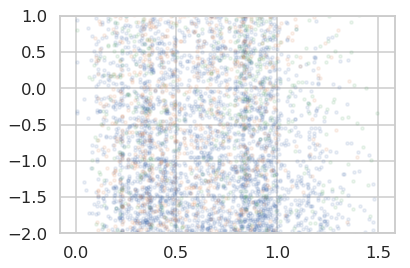

In [363]:
for i in range(3):
    plt.scatter(x_test1d_abs_rs[:,-1],x_test1d_abs_rs[:,i+1],s=10,alpha=0.1)
    plt.ylim(-2,1)

In [330]:
gp_root = '/data/des61.a/data/johnny/DESY3/galpro_files/DES_WF/'
gpmodel3 = model.Model('model_AbsMag_RSO', x_train1d_abs_rs, y_train1d_rs, x_target_abs_rs, root=gp_root, save_model=True)


('path:', '/data/des61.a/data/johnny/DESY3/galpro_files/DES_WF/model_AbsMag_RSO/')
Training model...
Saved model.


In [331]:
zcut = (x_target[:,-1]<=zhigh)&(x_target[:,-1]>=zlow)
point_estimates3 = np.zeros_like(x_target_abs[:,-1])
point_estimates3[np.where(zcut)[0]] = gpmodel3.point_estimate(save_estimates=False, make_plots=True)

Generating point estimates...


In [332]:
mlow = 8.
res3 = point_estimates3-y_target
snmad1,mean1 = get_nmad(res3[zcut])
snmad11,mean11 = get_nmad(res3[(y_target_rs>mlow)&zcut])
print('z<0.3 and mass>%.2fE10'%mlow)
print('median, sigma: %.3f, %.3f'%(mean11,snmad11))
print('\n')

z<0.3 and mass>8.00E10
median, sigma: -0.214, 0.105




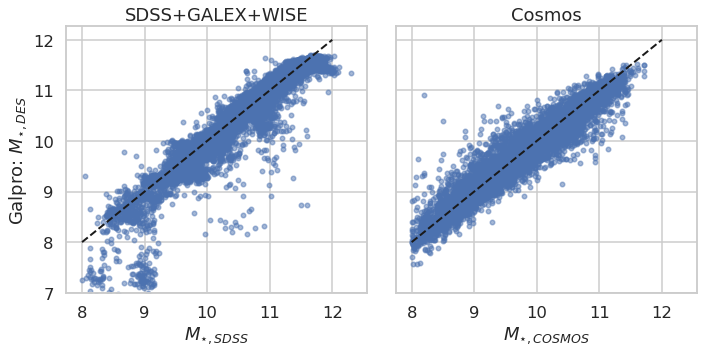

In [342]:
fig, axis = plt.subplots(1, 2, figsize=(10,5), sharex='all',sharey='all')
fig.subplots_adjust(wspace=0.04)
plot_scatter(y_test1d[y_test1d[:,0]>mlow,0],point_estimates[y_test1d[:,0]>mlow],
             ax=axis[1],s=20,alpha=0.5,title='Cosmos',xlims=(mlow,12.))

plot_scatter(y_target[(y_target>mlow)&zcut],-mean11+point_estimates3[(y_target_rs>mlow)&zcut],
             ax=axis[0],s=20,alpha=0.5,title='SDSS+GALEX+WISE',xlims=(mlow,12.))
axis[0].set_ylim(mlow-1,)
axis[0].set_xlabel(r'$M_{\star,SDSS}$')
axis[1].set_xlabel(r'$M_{\star,COSMOS}$')
axis[0].set_ylabel(r'Galpro: $M_{\star,DES}$')
fig.tight_layout()
fig.savefig('validation_galpro.png',dpi=100,transparent=False,facecolor='w')

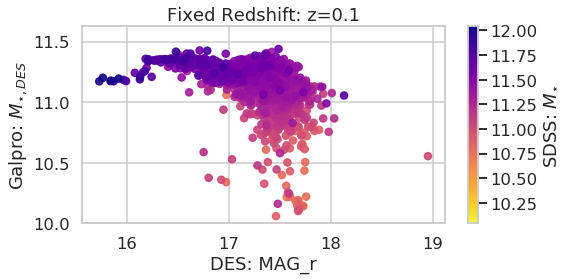

In [372]:
plt.figure(figsize=(8,4))
mask2 = (y_target>9.9)&(np.abs(x_target_abs[:,-1]-0.2)<0.01)
ix = np.argsort(y_target_rs[mask2])
plt.scatter(mags[mask2,1][ix],point_estimates3[mask2][ix],c=y_target[mask2][ix],s=50,alpha=0.9,cmap='plasma_r')
plt.colorbar().set_label('SDSS: $M_{\star}$')
plt.ylim(10.,)
plt.ylabel(r'Galpro: $M_{\star,DES}$')
plt.xlabel('DES: MAG_r')
plt.title('Fixed Redshift: z=0.1')
plt.tight_layout()
plt.savefig('validation_galpro_absMag_stellarMass_mag_fixed_redshift.png',dpi=100,transparent=False,facecolor='w')

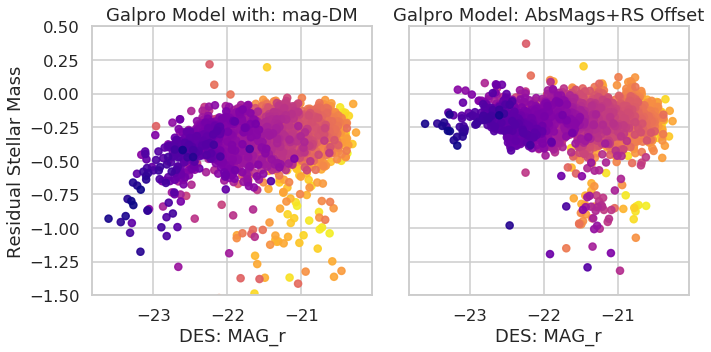

In [371]:
fig, axis = plt.subplots(1, 2, figsize=(10,5), sharex='all',sharey='all')
fig.subplots_adjust(wspace=0.01)

mask2 = (y_target>9.9)&(np.abs(x_target[:,-1]-0.1)<0.01)
ix = np.argsort(y_target[mask2])
axis[0].scatter(x_target_abs[mask2,1][ix],(point_estimates1-y_target)[mask2][ix],c=y_target[mask2][ix],
            s=50,alpha=0.9,cmap='plasma_r')
axis[0].set_title('Galpro Model with: mag-DM')

axis[1].scatter(x_target_abs[mask2,1][ix],res3[mask2][ix],c=y_target[mask2][ix],
            s=50,alpha=0.9,cmap='plasma_r')
axis[1].set_title('Galpro Model: AbsMags+RS Offset')

# axis[0].colorbar().set_label('SDSS: $M_{\star}$')
axis[0].set_ylim(-1.5,+.5)
axis[0].set_ylabel('Residual Stellar Mass')
axis[0].set_xlabel('DES: MAG_r')
axis[1].set_xlabel('DES: MAG_r')


plt.tight_layout()
plt.savefig('validation_galpro_mag_residual_fixed_redshift.png',dpi=100,transparent=False,facecolor='w')

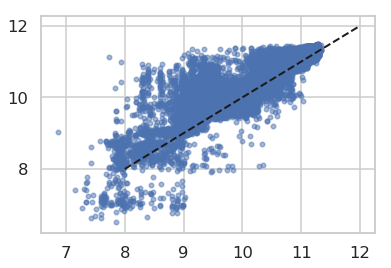

In [345]:
plot_scatter(point_estimates0[zcut],point_estimates3[zcut])

### Feature Importance

In [368]:
import time
import numpy as np

forest = gpmodel3.model
start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print("Elapsed time to compute the importances: {elapsed_time:.3f} seconds".format(elapsed_time=elapsed_time))

Elapsed time to compute the importances: 0.698 seconds


In [369]:
feature_names = ['Abs_mag_%s'%bpF for bpF in ['i']]
feature_names+= [r'$\Delta (%s - %s)_{rs}$'%(bp0,bp1) for bp0, bp1 in zip(['g','r','i'],['r','i','z'])]

feature_names+= ['Mag_err_%s'%bpF for bpF in ['i']]
feature_names+= ['Err(%s - %s)'%(bp0,bp1) for bp0, bp1 in zip(['g','r','i'],['r','i','z'])]
feature_names+= ['redshift']
feature_names

['Abs_mag_i',
 '$\\Delta (g - r)_{rs}$',
 '$\\Delta (r - i)_{rs}$',
 '$\\Delta (i - z)_{rs}$',
 'Mag_err_i',
 'Err(g - r)',
 'Err(r - i)',
 'Err(i - z)',
 'redshift']

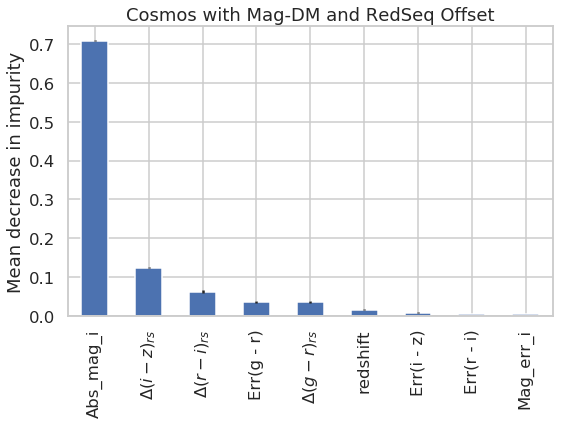

In [370]:
import pandas as pd

ix = np.argsort(-1*importances)
forest_importances = pd.Series(importances[ix], index=np.array(feature_names)[ix])

fig, ax = plt.subplots(figsize=(8,6))
forest_importances.plot.bar(yerr=std[ix], ax=ax)
ax.set_title("Cosmos with Mag-DM and RedSeq Offset")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
fig.savefig('feature_importance_mag_dm_rs.png',dpi=100,transparent=False,facecolor='w')

## With RS Width

In [365]:
# redshift cut
zlow, zhigh = 0.0, 1.5
x_target_abs_rs = get_input_galpro3(mags,ztrue,normalize=False)
x_test1d_abs_rs = get_input_galpro3(x_test1d[:,:4],x_test1d[:,-1],normalize=False)
x_train1d_abs_rs = get_input_galpro3(x_train1d[:,:4],x_train1d[:,-1],normalize=False)

zcut = (x_train1d_abs[:,-1]>=zlow)&(x_train1d_abs[:,-1]<=zhigh) 
y_train1d_rs = y_train1d[zcut]

zcut1 = (x_test1d[:,-1]>=zlow)&(x_test1d[:,-1]<=zhigh) 
y_test1d_rs = y_test1d[zcut1]

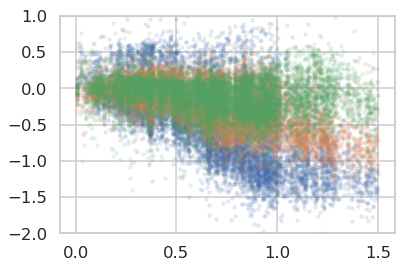

In [367]:
for i in range(3):
    plt.scatter(x_test1d_abs_rs[:,-1],x_test1d_abs_rs[:,i+1],s=10,alpha=0.1)
#     plt.ylim(-50,50)
    plt.ylim(-2,1)

In [330]:
gp_root = '/data/des61.a/data/johnny/DESY3/galpro_files/DES_WF/'
gpmodel3 = model.Model('model_AbsMag_RSO', x_train1d_abs_rs, y_train1d_rs, x_target_abs_rs, root=gp_root, save_model=True)


('path:', '/data/des61.a/data/johnny/DESY3/galpro_files/DES_WF/model_AbsMag_RSO/')
Training model...
Saved model.


In [331]:
zcut = (x_target[:,-1]<=zhigh)&(x_target[:,-1]>=zlow)
point_estimates3 = np.zeros_like(x_target_abs[:,-1])
point_estimates3[np.where(zcut)[0]] = gpmodel3.point_estimate(save_estimates=False, make_plots=True)

Generating point estimates...


In [332]:
mlow = 8.
res3 = point_estimates3-y_target
snmad1,mean1 = get_nmad(res3[zcut])
snmad11,mean11 = get_nmad(res3[(y_target_rs>mlow)&zcut])
print('z<0.3 and mass>%.2fE10'%mlow)
print('median, sigma: %.3f, %.3f'%(mean11,snmad11))
print('\n')

z<0.3 and mass>8.00E10
median, sigma: -0.214, 0.105




In [82]:
# np.median(x_train1d_abs_rs)

In [99]:
# for i in range(3):
#     plt.hist(x_test1d_abs_rs[:,i+4],
#              bins=np.linspace(-2,1,21),histtype='step',lw=3)

In [100]:
# for i in range(3):
#     plt.hist(x_target_abs_rs[:,i+4],
#              bins=np.linspace(-2,1,21),histtype='step',lw=3)